In [584]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [585]:
import pandas as pd

In [586]:
import numpy as np

In [587]:
# Define function to compute saturation vapor pressure in Pa, given temperature in C.
def esat(TC):
    return(611.2*np.exp(17.67*TC/(TC+243.5)))

#=================

# Define function to compute saturation mixing ratio, given temperature in K and pressure in Pa
def wsat(TK,p):
    es = esat(TK-273.15)
    return(0.622*es/(p-es))

In [588]:
from scipy.constants import g, C2K, K2C

In [589]:
# Read sonde

with open('91408_2011_07_19_12.txt') as sonde_fp:
    for lineno, line in enumerate(sonde_fp):
        if 'Station information' in line:
            footer_start = lineno
        if '----' in line:
            header_end = lineno+1
    footer_end = lineno
    
sonde = pd.read_table('91408_2011_07_19_12.txt', sep='\s+', header=None, skiprows=range(header_end)+range(footer_start,footer_end+1),
              names=[
                'pressure',
                'height',
                'temperature',
                'dewpoint',
                'rh',
                'mixing_ratio'
                ],
               usecols=range(6)
             )
# Set pressure as index
sonde.set_index('pressure', drop=False, inplace=True)

# Remove incomplete rows
sonde.dropna(inplace=True)

# Remove extra columns
sonde.drop(['rh','mixing_ratio','height'], inplace=True, axis=1)

# Ensure monotonicity
non_monotonic = pd.np.nonzero(pd.np.diff(sonde.index) > 0)[0] + 1
sonde.iloc[non_monotonic] = pd.np.NAN
sonde.dropna(inplace=True)
assert sonde.index.is_monotonic_decreasing

# Convert hPa to Pa
sonde.index *= 100
sonde.pressure *= 100
print 'Read',sonde.shape[0],'rows'

Read 123 rows


In [590]:
assumed_levels = pd.DataFrame({'temperature':[-50.0], 'dewpoint':[-80.0], 'pressure':[100.0]}, index=[100.0])
assumed_levels.index.name = 'pressure'
assumed_levels

,dewpoint,pressure,temperature
pressure,,,
100.0,-80.0,100.0,-50.0


In [591]:
profile = pd.concat([assumed_levels, sonde], join='inner').sort_index()

In [592]:
levels = .9 ** (np.arange(100)/2.) * 100000
levels

array([ 100000.        ,   94868.32980505,   90000.        ,
         85381.49682455,   81000.        ,   76843.34714209,
         72900.        ,   69159.01242788,   65610.        ,
         62243.11118509,   59049.        ,   56018.80006658,
         53144.1       ,   50416.92005993,   47829.69      ,
         45375.22805393,   43046.721     ,   40837.70524854,
         38742.0489    ,   36753.93472369,   34867.84401   ,
         33078.54125132,   31381.059609  ,   29770.68712619,
         28242.9536481 ,   26793.61841357,   25418.65828329,
         24114.25657221,   22876.79245496,   21702.83091499,
         20589.11320946,   19532.54782349,   18530.20188852,
         17579.29304114,   16677.18169967,   15821.36373703,
         15009.4635297 ,   14239.22736332,   13508.51717673,
         12815.30462699,   12157.66545906,   11533.77416429,
         10941.89891315,   10380.39674786,    9847.70902184,
          9342.35707308,    8862.93811965,    8408.12136577,
          7976.64430769,

In [593]:
profile.head()

,pressure,temperature,dewpoint
pressure,,,
100.0,100.0,-50.0,-80.0
850.0,850.0,-38.7,90.0
930.0,930.0,-43.9,90.0
970.0,970.0,-43.9,90.0
1000.0,1000.0,-45.3,90.0


In [594]:
#standard_profile = pd.concat([profile,profile.loc[levels]]).sort_index().interpolate().loc[levels].dropna()
#standard_profile.drop_duplicates(inplace=True
standard_profile = pd.DataFrame({k:np.interp(levels, profile.index, profile[k].values) for k in profile}, index=levels)

In [595]:
standard_profile.tail()

,dewpoint,pressure,temperature
670.685934,49.355478,670.685934,-41.401665
636.268544,41.554203,636.268544,-41.920221
603.617341,34.153264,603.617341,-42.412165
572.641690,27.132116,572.641690,-42.878865
543.255607,20.471271,543.255607,-43.321616


In [596]:
#TODO interpolate

In [597]:
standard_profile['q_vap'] = 0.622 * (standard_profile.dewpoint.apply(esat) / standard_profile.pressure)

In [598]:
means = standard_profile.rolling(window=2).mean().dropna()
deltas = standard_profile.diff().rename(columns = lambda x: 'delta_'+x).dropna()
layers = means.join(deltas).reset_index(drop=True)

In [599]:
layers['mass'] = -layers.delta_pressure / g

In [600]:
layers['wvmass'] = layers.q_vap*layers.mass

In [601]:
layers['delta_z'] = 287.06*layers.temperature.apply(C2K)*(1.+0.61*layers.q_vap)*log(1/np.sqrt(.9))/9.80665

In [602]:
layers.tail()

,dewpoint,pressure,temperature,q_vap,delta_dewpoint,delta_pressure,delta_temperature,delta_q_vap,mass,wvmass,delta_z
94,53.467111,688.825492,-41.128363,13.459420,-8.223266,-36.279115,-0.546605,-4.644993,3.699440,49.792319,3295.335417
95,45.454841,653.477239,-41.660943,9.494818,-7.801275,-34.417390,-0.518555,-3.284211,3.509597,33.322986,2424.475234
96,37.853734,619.942942,-42.166193,6.694157,-7.400939,-32.651203,-0.491945,-2.317111,3.329496,22.288171,1810.667848
97,30.642690,588.129515,-42.645515,4.719501,-7.021148,-30.975651,-0.466700,-1.632203,3.158637,14.907191,1378.755748
98,23.801694,557.948648,-43.100240,3.329117,-6.660845,-29.386083,-0.442750,-1.148564,2.996547,9.975854,1075.160840


In [606]:
z = layers.delta_z.cumsum()
z[-1] = 0
layers['z'] = z.sort_index().rolling(window=2).mean()

In [608]:
layers['rho'] = layers.mass / layers.delta_z
layers['rho_wv'] = layers.wvmass / layers.delta_z

In [609]:
layers.tail()

,dewpoint,pressure,temperature,q_vap,delta_dewpoint,delta_pressure,delta_temperature,delta_q_vap,mass,wvmass,delta_z,z,rho,rho_wv
94,53.467111,688.825492,-41.128363,13.459420,-8.223266,-36.279115,-0.546605,-4.644993,3.699440,49.792319,3295.335417,219669.437731,0.001123,0.015110
95,45.454841,653.477239,-41.660943,9.494818,-7.801275,-34.417390,-0.518555,-3.284211,3.509597,33.322986,2424.475234,222529.343056,0.001448,0.013744
96,37.853734,619.942942,-42.166193,6.694157,-7.400939,-32.651203,-0.491945,-2.317111,3.329496,22.288171,1810.667848,224646.914597,0.001839,0.012309
97,30.642690,588.129515,-42.645515,4.719501,-7.021148,-30.975651,-0.466700,-1.632203,3.158637,14.907191,1378.755748,226241.626395,0.002291,0.010812
98,23.801694,557.948648,-43.100240,3.329117,-6.660845,-29.386083,-0.442750,-1.148564,2.996547,9.975854,1075.160840,227468.584690,0.002787,0.009278


In [610]:
import gasabsr98

In [611]:
f = 54.4000

In [612]:
def get_weighting_function(f):
    layers['ke_air'] = layers.apply(lambda s: gasabsr98.gasabsr98(f,C2K(s.temperature), s.rho_wv, s.pressure)[0], axis=1)
    layers['ke_wv'] = layers.apply(lambda s: gasabsr98.gasabsr98(f,C2K(s.temperature), s.rho_wv, s.pressure)[1], axis=1)
    
    layers['tau'] = (layers.ke_air*layers.mass + layers.ke_wv*layers.wvmass)
    return pd.Series(
        # W(z) = -dt(z)/dz
        -np.diff(
            # t(z) = e^-tau(z)
            np.exp(
                # tau(z) = integral from top to z of tau
                -layers.tau.values[::-1].cumsum()
            )
        ),
        index=layers.z[1:]
    )

In [613]:
get_weighting_function(f)

z
693.357627       6.499470e-02
1150.268360      9.958009e-02
1603.062729      1.406258e-01
2051.271993      1.772099e-01
2495.042248      1.893371e-01
2934.932399      1.585771e-01
3370.731009      9.261903e-02
3802.084784      3.088439e-02
4229.391607      5.577246e-03
4653.184674      6.405399e-04
5073.831271      5.759907e-05
5491.313531      4.084609e-06
5905.179437      2.170269e-07
6315.263401      9.566851e-09
6721.653315      3.771542e-10
7124.406992      1.294235e-11
7523.477447      3.648653e-13
7918.713306      8.564214e-15
8309.974184      1.750298e-16
8697.049236      3.006355e-18
9079.695467      2.953008e-20
9457.797859      1.268842e-22
9831.184657      4.571031e-25
10199.647936     2.559778e-27
10563.258668     1.438007e-29
10922.197592     2.892752e-32
11276.484737     1.172562e-35
11626.081045     4.997657e-40
11971.042788     1.327275e-45
12311.457738     2.019219e-52
                     ...     
50706.259642     5.652216e-91
56766.893857     5.997739e-91
62208.84

In [614]:
amsu_a = pd.Series(
    {
        3:  50.3000,
        4:  52.8000,
        5:  53.7110,
        6:  54.4000,
        7:  54.9400,
        8:  55.5000,
        9:  57.2900,
        10: 57.5070
    }
)

amsu_b = pd.Series(
    {
       16: 89.00,
        17: 150.0,
        18: 184.31,
        19: 186.31,
        20: 190.31
    }
)

In [615]:
weighting_functions = pd.DataFrame({ channel:get_weighting_function(amsu_a[channel]) for channel in amsu_a.index})

(0, 40000)

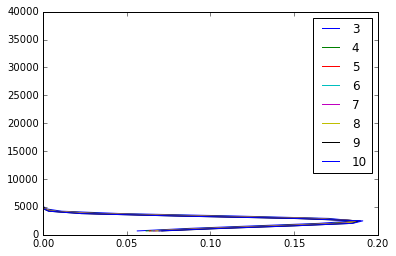

In [616]:
plot(weighting_functions, weighting_functions.index)
legend(amsu_a.index, loc='best')
ylim([0,40000])